# The purpose of this notebook is to calculate the Weight of Evidence (WOE) and Information Value (IV) for each predictor variable in our cleaned dataset.

### WOE and IV help us identify which variables have the strongest predictive power in distinguishing good (non-default) vs bad (default) borrowers for our Elder-Care Support Loan credit scorecard.

In [11]:
import pandas as pd
import numpy as np
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 120)

DATA_PATH = Path("merged_applicant_and_bureau_cleaned_2.csv")   
OUT_DIR = Path("woe_iv_outputs")                              # local subfolder for outputs
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [12]:
TARGET_COL = "TARGET"   # 0 = good, 1 = bad 

In [13]:
# Load your cleaned dataset
df = pd.read_csv(DATA_PATH)

# Quick checks
print("Shape:", df.shape)
print("Columns:", df.columns.tolist()[:20])  # show first 20 columns
df[TARGET_COL].value_counts(dropna=False)
df.head()


Shape: (254358, 29)
Columns: ['Unnamed: 0', 'SK_ID_CURR', 'TARGET', 'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'OCCUPATION_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'AGE', 'AMT_CREDIT_SUM_sum', 'AMT_CREDIT_SUM_DEBT_sum', 'AMT_CREDIT_SUM_OVERDUE_max', 'CREDIT_DAY_OVERDUE_max', 'CNT_CREDIT_PROLONG_sum', 'CREDIT_ACTIVE_Active']


,Unnamed: 0,SK_ID_CURR,TARGET,NAME_INCOME_TYPE,NAME_FAMILY_STATUS,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,OCCUPATION_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,AGE,AMT_CREDIT_SUM_sum,AMT_CREDIT_SUM_DEBT_sum,AMT_CREDIT_SUM_OVERDUE_max,CREDIT_DAY_OVERDUE_max,CNT_CREDIT_PROLONG_sum,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Closed,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Microloan,CREDIT_TYPE_Unknown type of loan,CREDIT_TYPE_Another type of loan,DEBT_RATIO,OVERDUE_RATIO,YEARS_EMPLOYED
0,0,100003,0,State servant,Married,0,270000.0,1293502.5,35698.5,1129500.0,Core staff,N,N,45.931507,94900.5,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3.254795
1,1,100004,0,Working,Single / not married,0,67500.0,135000.0,6750.0,135000.0,Laborers,Y,Y,52.180822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.616438
2,2,100006,0,Working,Civil marriage,0,135000.0,312682.5,29686.5,297000.0,Laborers,N,Y,52.068493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.326027
3,3,100007,0,Working,Single / not married,0,121500.0,513000.0,21865.5,513000.0,Core staff,N,Y,54.608219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.323288
4,4,100008,0,State servant,Married,0,99000.0,490495.5,27517.5,454500.0,Laborers,N,Y,46.413699,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.350685


# Function takes in a data frame for a variable with columns: variable values, 'TARGET' values, bin range corresponding to varaible value.

In [14]:
def woe_iv(data):
    working_data = data.copy() 
    working_data['Bin_Range'] = working_data['Bin_Range'].astype('object')
    working_data['Bin_Range'].fillna('Missing', inplace=True)
    
    variable_data = pd.DataFrame()
    variable_data['Bin_Range'] = working_data.groupby(by='Bin_Range', as_index=False).count()['Bin_Range']
    variable_data['Count'] = working_data.groupby(by='Bin_Range', as_index=False).count()['TARGET']
    variable_data['Events'] = working_data.groupby(by='Bin_Range', as_index=False).sum()['TARGET']
    variable_data['Non_Events'] = variable_data['Count'] - variable_data['Events']
    
    # Add small constant to avoid division by zero
    variable_data['%_of_Events'] = (variable_data['Events'] + 0.5) / (sum(variable_data['Events']) + 0.5 * len(variable_data))
    variable_data['%_of_Non_Events'] = (variable_data['Non_Events'] + 0.5) / (sum(variable_data['Non_Events']) + 0.5 * len(variable_data))
    
    variable_data['WOE'] = np.log(variable_data['%_of_Non_Events'] / variable_data['%_of_Events'])
    variable_data['IV'] = (variable_data['%_of_Non_Events'] - variable_data['%_of_Events']) * variable_data['WOE']
    variable_data['total_IV'] = variable_data['IV'].sum()
    
    return variable_data

# # test the function
# df_bin_data = df.loc[:,('AMT_CREDIT', 'TARGET')].copy()
# df_bin_data['Bin_Range'] = pd.qcut(df['AMT_CREDIT'], q=20)
# woe_iv(df_bin_data)

# Function to calculate WOE, IV and plot IV

In [15]:
# create IV calc and WOE plotting function
def woe_iv_plot(data, variable_name):
    variable_data = woe_iv(data)
    print('IV for', variable_name, 'with', variable_data.shape[0], 'bins:', round(variable_data.loc[0,'total_IV'],4))
    ffig, ax1 = plt.subplots(figsize=(20,6))

    # if 'missing' bin, do not include in plot
    if variable_data['Bin_Range'].isin(['Missing']).sum() > 0:
        sns.lineplot(data = variable_data['WOE'].iloc[0:-1], marker='o', sort = False, ax=ax1)
    else:
        sns.lineplot(data = variable_data['WOE'], marker='o', sort = False, ax=ax1)
    plt.xticks(rotation=45)

    # if 'missing' bin, create the scatter plot to plot the Missing WOE data point
    if variable_data['Bin_Range'].isin(['Missing']).sum() > 0: 
        last_point = len(variable_data['WOE']) - 1
        scatter_plot = sns.scatterplot(x=[last_point], y=[variable_data['WOE'][last_point]], color='b', s=30, ax=ax1)
    
    ax2 = ax1.twinx()
    
    # Calculate percentages instead of using raw counts
    total_count = variable_data['Count'].sum()
    variable_data['Percent'] = (variable_data['Count'] / total_count) * 100
        
    # plot the bin percentages instead of counts
    sns.barplot(x = variable_data['Bin_Range'], y = variable_data['Percent'], alpha=0.5, ax = ax2, color = 'deepskyblue')
    
    # Update y-axis label to reflect percentage
    ax2.set_ylabel('Percent of Observations (%)')
    
    plt.title("WOE plot for " + variable_name)
    plt.show()
    

IV for AMT_CREDIT with 5 bins: 0.0402


/var/folders/69/hc5tv1pn547clcgc4pkpgsp80000gn/T/ipykernel_27945/1750641458.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
/var/folders/69/hc5tv1pn547clcgc4pkpgsp80000gn/T/ipykernel_27945/3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting va

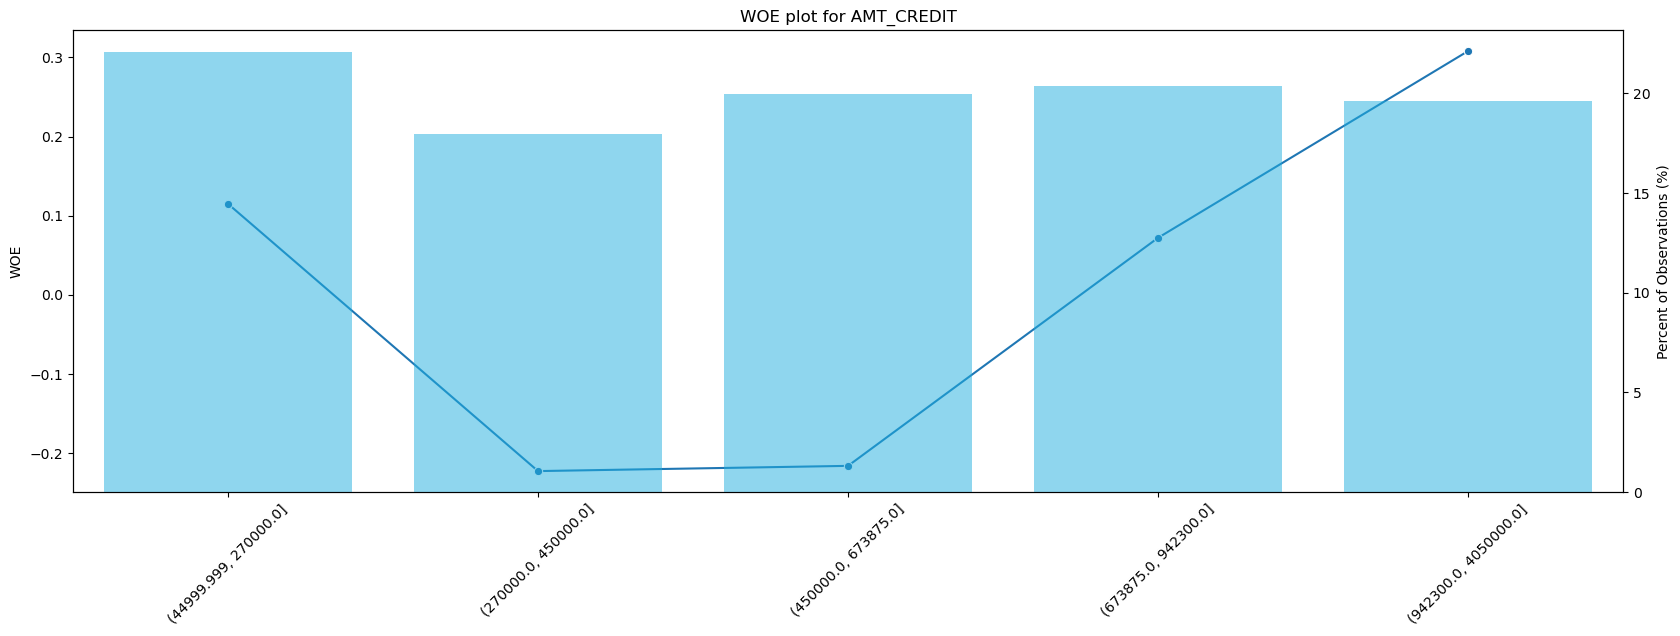

In [16]:
# test the function - create a copy first
variable = 'AMT_CREDIT'
woe_bin_data = df.loc[:,(variable, 'TARGET')].copy()
woe_bin_data['Bin_Range'] = pd.qcut(df[variable], q=5)
woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
woe_iv_plot(woe_bin_data, variable)

# Coarse classing Uses pd.cut to do coarse classing using equal width bins to calcualte IV and plot WOE

/var/folders/69/hc5tv1pn547clcgc4pkpgsp80000gn/T/ipykernel_27945/3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  working_data['Bin_Range'].fillna('Missing', inplace=True)


IV for AMT_CREDIT with 6 bins: 0.0471


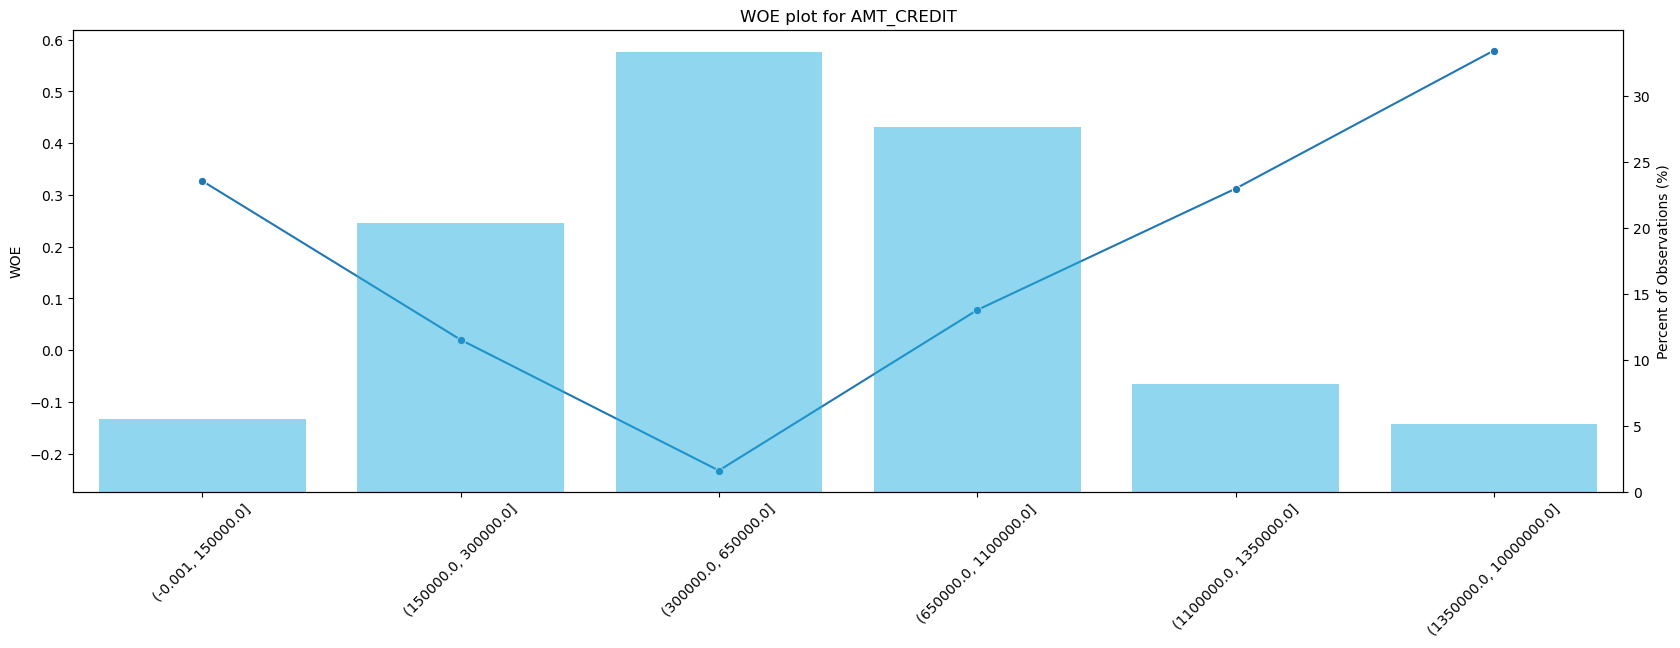

In [17]:
# sample code

bin_edges = [0, 150000, 300000, 650000, 1100000, 1350000, 10000000]
variable = 'AMT_CREDIT'

# create groupings based on specified bin edges
df['Bin_Range'] = pd.cut(df[variable], bins = bin_edges, include_lowest= True)
df['Bin_Range'].value_counts().sort_index()

woe_iv_plot(df, variable)


### YEARS_EMPLOYED

IV for YEARS_EMPLOYED with 6 bins: 0.0942


/var/folders/69/hc5tv1pn547clcgc4pkpgsp80000gn/T/ipykernel_27945/1003524567.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
/var/folders/69/hc5tv1pn547clcgc4pkpgsp80000gn/T/ipykernel_27945/3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting va

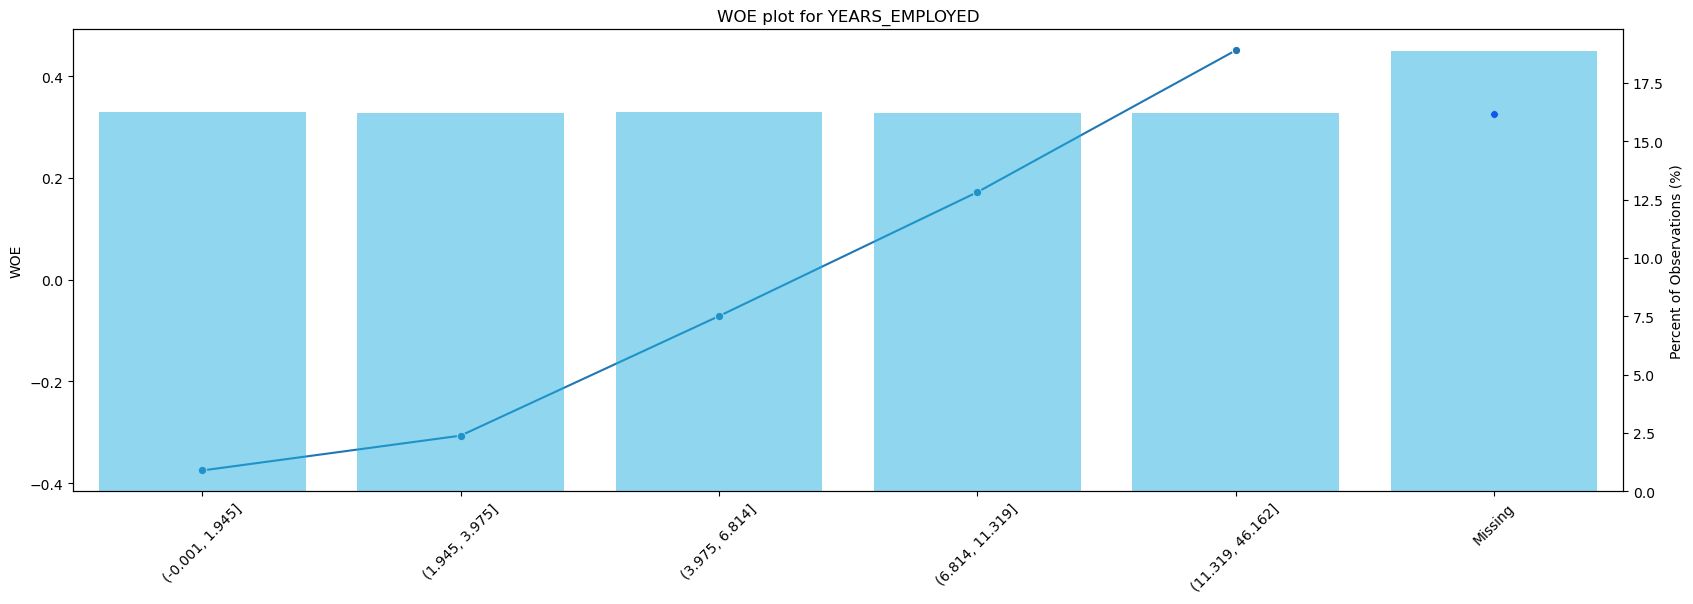

In [18]:
# test the function - create a copy first
variable = 'YEARS_EMPLOYED'
woe_bin_data = df.loc[:,(variable, 'TARGET')].copy()
woe_bin_data['Bin_Range'] = pd.qcut(df[variable], q=5)
woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
woe_iv_plot(woe_bin_data, variable)

/var/folders/69/hc5tv1pn547clcgc4pkpgsp80000gn/T/ipykernel_27945/3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  working_data['Bin_Range'].fillna('Missing', inplace=True)


IV for YEARS_EMPLOYED with 5 bins: 0.0937


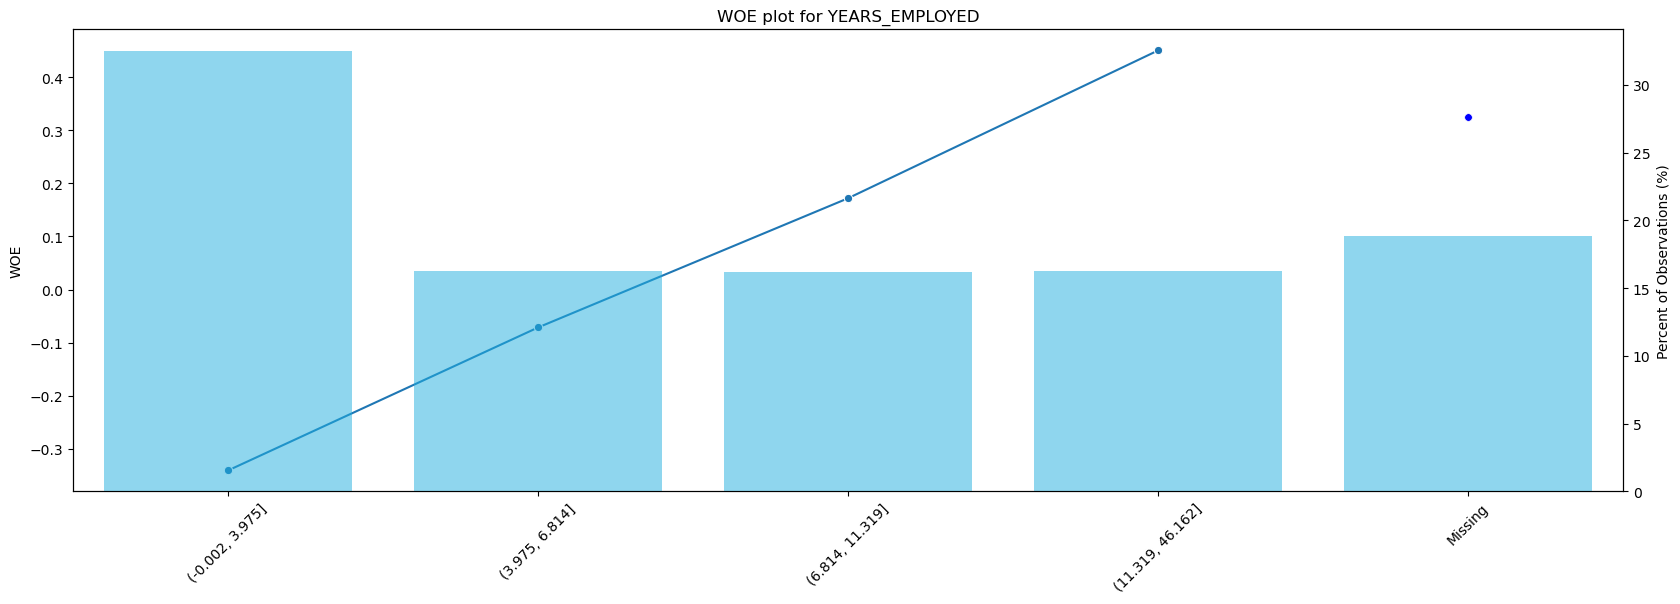

In [19]:
# sample code

bin_edges = [-0.001, 3.975, 6.814, 11.319, 46.162]
variable = 'YEARS_EMPLOYED'

# create groupings based on specified bin edges
df['Bin_Range'] = pd.cut(df[variable], bins = bin_edges, include_lowest= True)
df['Bin_Range'].value_counts().sort_index()

woe_iv_plot(df, variable)


### DEBT_RATIO

IV for DEBT_RATIO with 6 bins: 0.0525


/var/folders/69/hc5tv1pn547clcgc4pkpgsp80000gn/T/ipykernel_27945/1308165285.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
/var/folders/69/hc5tv1pn547clcgc4pkpgsp80000gn/T/ipykernel_27945/3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting va

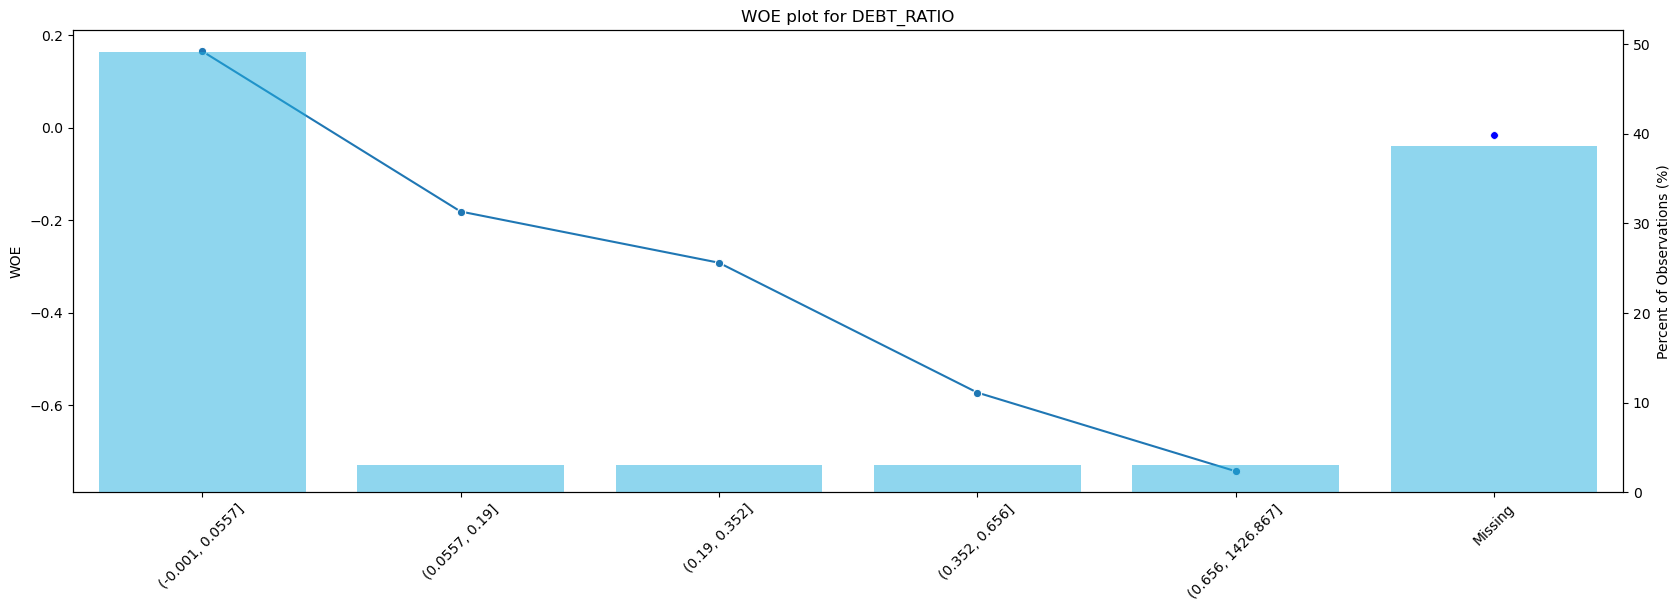

In [20]:
# test the function - create a copy first
variable = 'DEBT_RATIO'
woe_bin_data = df.loc[:,(variable, 'TARGET')].copy()
woe_bin_data['Bin_Range'] = pd.qcut(df[variable], q=20, duplicates='drop')
woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
woe_iv_plot(woe_bin_data, variable)

/var/folders/69/hc5tv1pn547clcgc4pkpgsp80000gn/T/ipykernel_27945/3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  working_data['Bin_Range'].fillna('Missing', inplace=True)


IV for DEBT_RATIO with 4 bins: 0.0517


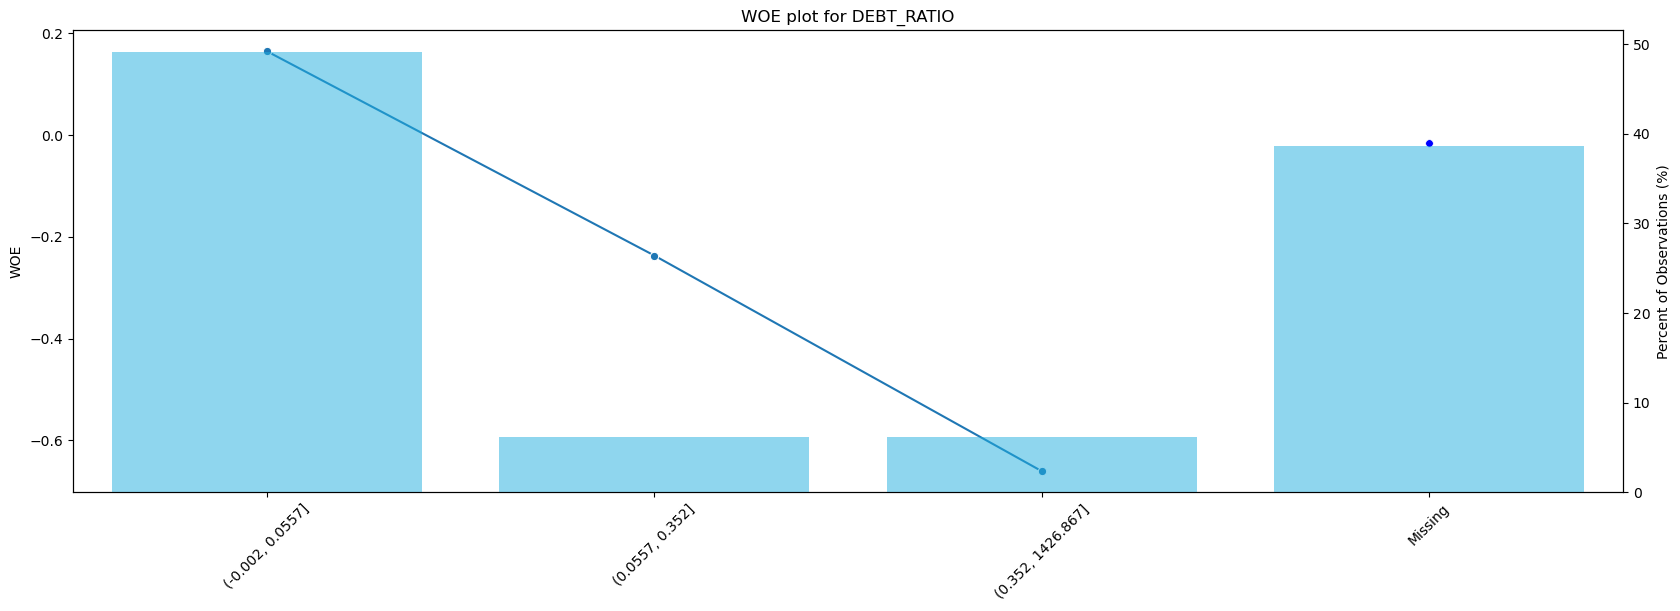

In [21]:
# sample code

bin_edges = [-0.001, 0.0557, 0.352, 1426.867]
variable = 'DEBT_RATIO'

# create groupings based on specified bin edges
df['Bin_Range'] = pd.cut(df[variable], bins = bin_edges, include_lowest= True)
df['Bin_Range'].value_counts().sort_index()

woe_iv_plot(df, variable)


### AMT_CREDIT_SUM_DEBT_sum

IV for AMT_CREDIT_SUM_DEBT_sum with 6 bins: 0.0479


/var/folders/69/hc5tv1pn547clcgc4pkpgsp80000gn/T/ipykernel_27945/3052190614.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
/var/folders/69/hc5tv1pn547clcgc4pkpgsp80000gn/T/ipykernel_27945/3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting va

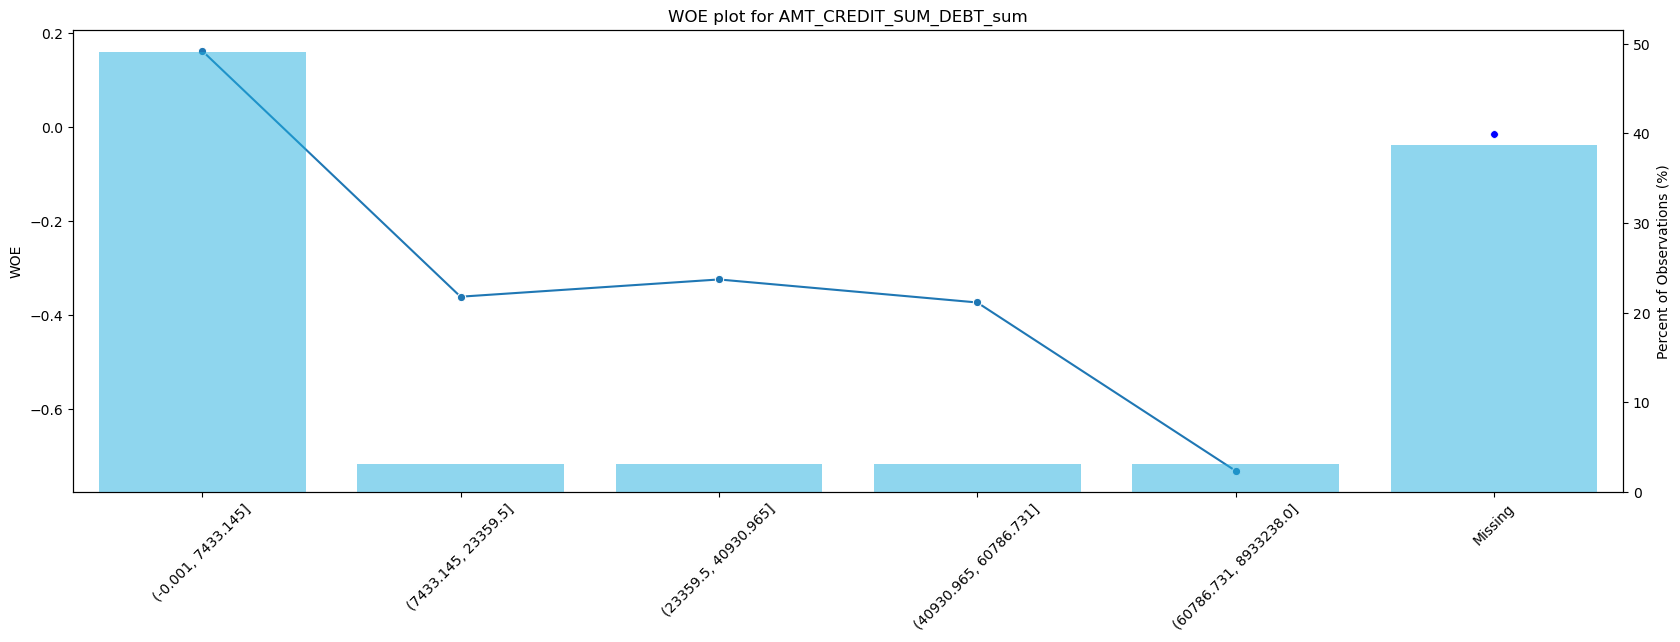

In [22]:
# test the function - create a copy first
variable = 'AMT_CREDIT_SUM_DEBT_sum'
woe_bin_data = df.loc[:,(variable, 'TARGET')].copy()
woe_bin_data['Bin_Range'] = pd.qcut(df[variable], q=20, duplicates="drop")
woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
woe_iv_plot(woe_bin_data, variable)

/var/folders/69/hc5tv1pn547clcgc4pkpgsp80000gn/T/ipykernel_27945/3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  working_data['Bin_Range'].fillna('Missing', inplace=True)


IV for AMT_CREDIT_SUM_DEBT_sum with 5 bins: 0.0483


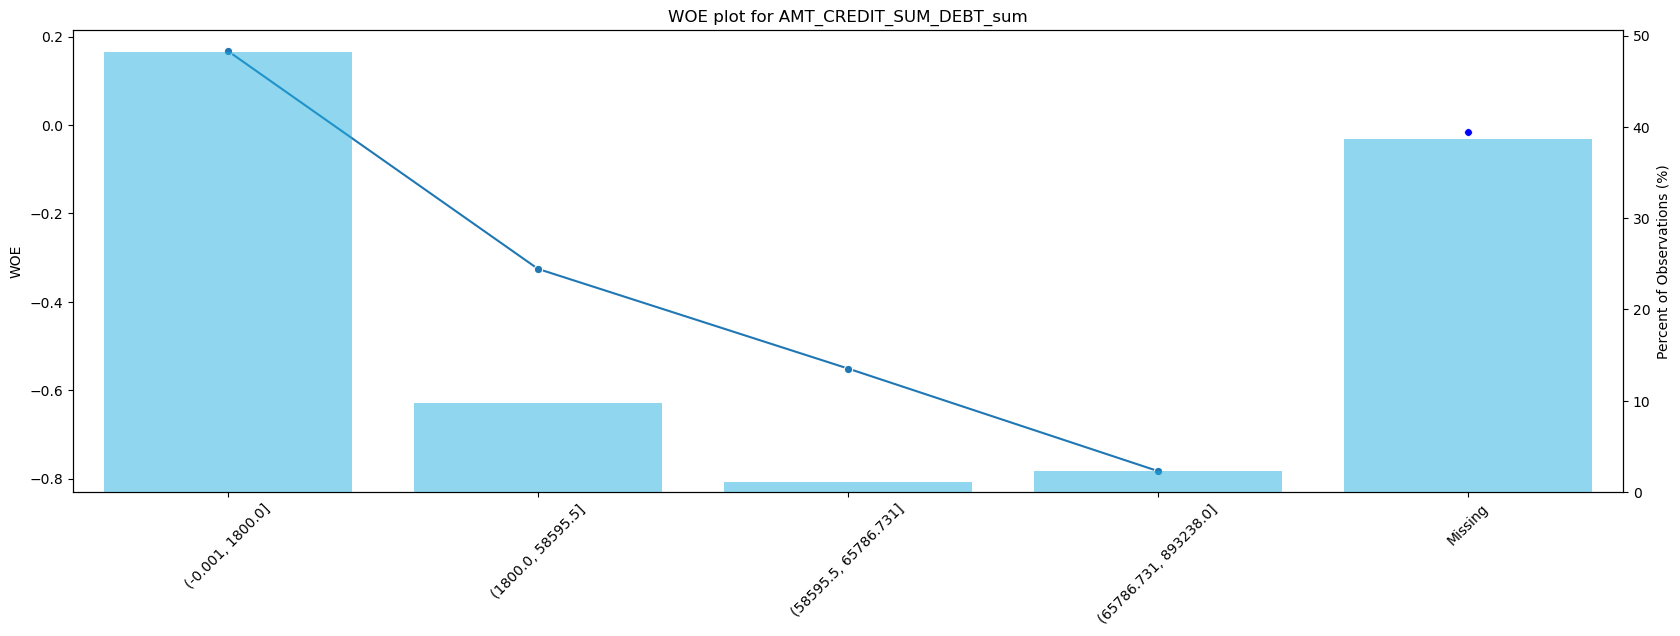

In [23]:
# sample code

bin_edges = [0, 1800, 58595.5, 65786.731, 893238.0]
variable = 'AMT_CREDIT_SUM_DEBT_sum'

# create groupings based on specified bin edges
df['Bin_Range'] = pd.cut(df[variable], bins = bin_edges, include_lowest= True)
df['Bin_Range'].value_counts().sort_index()

woe_iv_plot(df, variable)


### AGE

IV for AGE with 6 bins: 0.0539


/var/folders/69/hc5tv1pn547clcgc4pkpgsp80000gn/T/ipykernel_27945/2776209989.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
/var/folders/69/hc5tv1pn547clcgc4pkpgsp80000gn/T/ipykernel_27945/3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting va

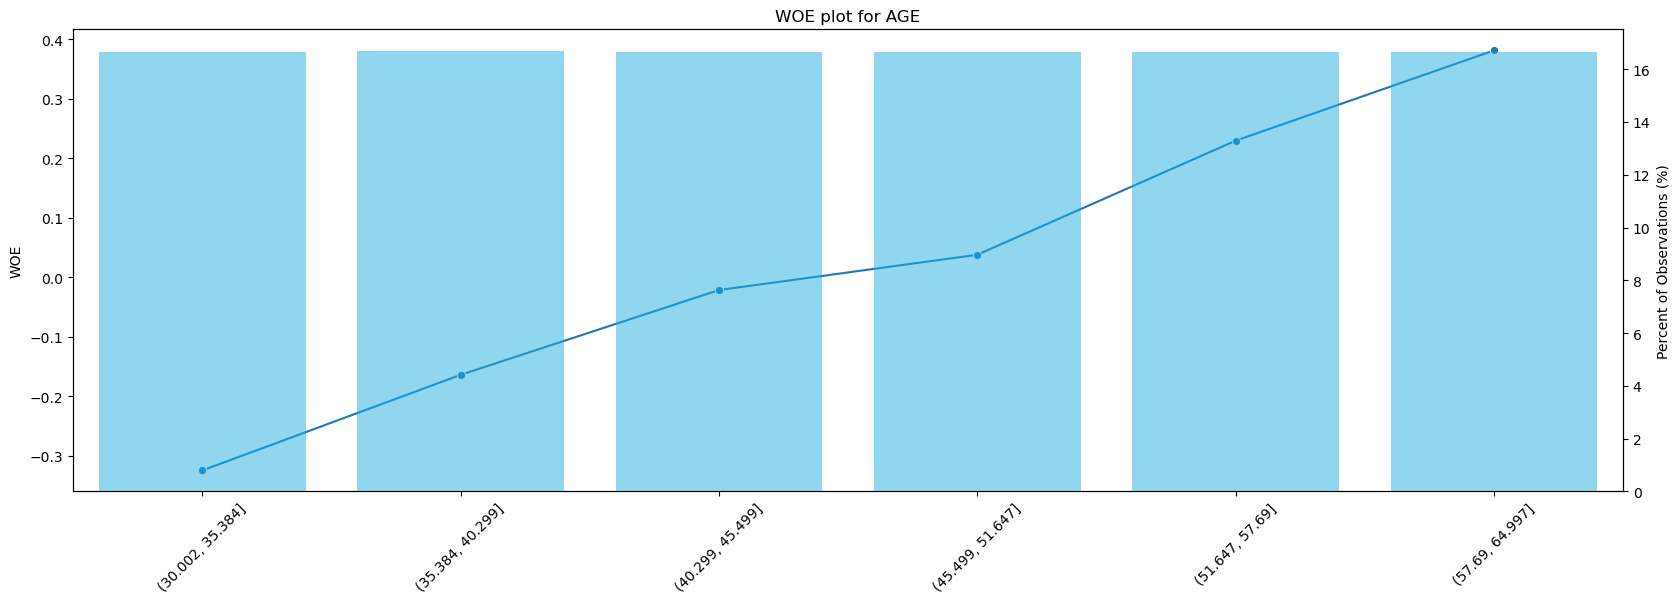

In [24]:
# test the function - create a copy first
variable = 'AGE'
woe_bin_data = df.loc[:,(variable, 'TARGET')].copy()
woe_bin_data['Bin_Range'] = pd.qcut(df[variable], q=6)
woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
woe_iv_plot(woe_bin_data, variable)

/var/folders/69/hc5tv1pn547clcgc4pkpgsp80000gn/T/ipykernel_27945/3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  working_data['Bin_Range'].fillna('Missing', inplace=True)


IV for AGE with 4 bins: 0.0499


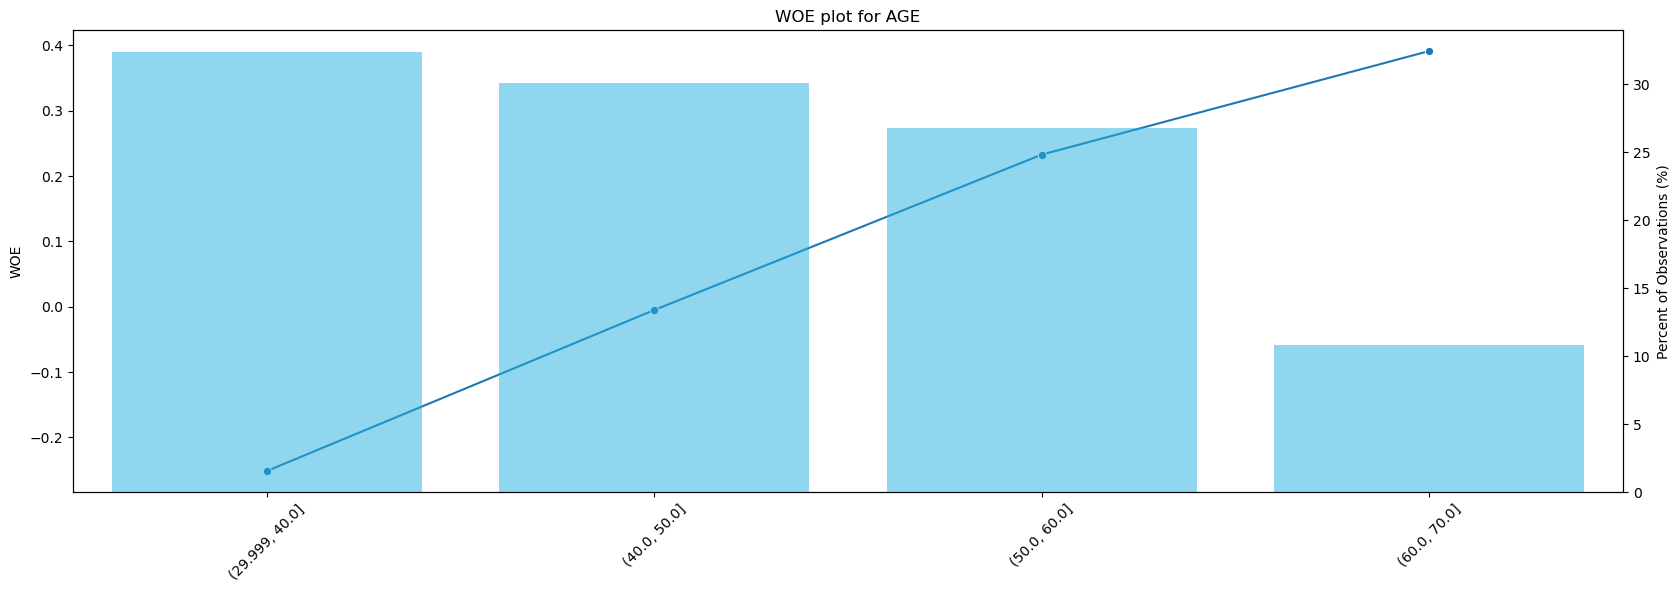

In [25]:
# sample code

bin_edges = [30, 40, 50, 60,  70]
variable = 'AGE'

# create groupings based on specified bin edges
df['Bin_Range'] = pd.cut(df[variable], bins = bin_edges, include_lowest= True)
df['Bin_Range'].value_counts().sort_index()

woe_iv_plot(df, variable)


### CREDIT_ACTIVE_Active

IV for CREDIT_ACTIVE_Active with 5 bins: 0.0191


/var/folders/69/hc5tv1pn547clcgc4pkpgsp80000gn/T/ipykernel_27945/446180054.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
/var/folders/69/hc5tv1pn547clcgc4pkpgsp80000gn/T/ipykernel_27945/3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting val

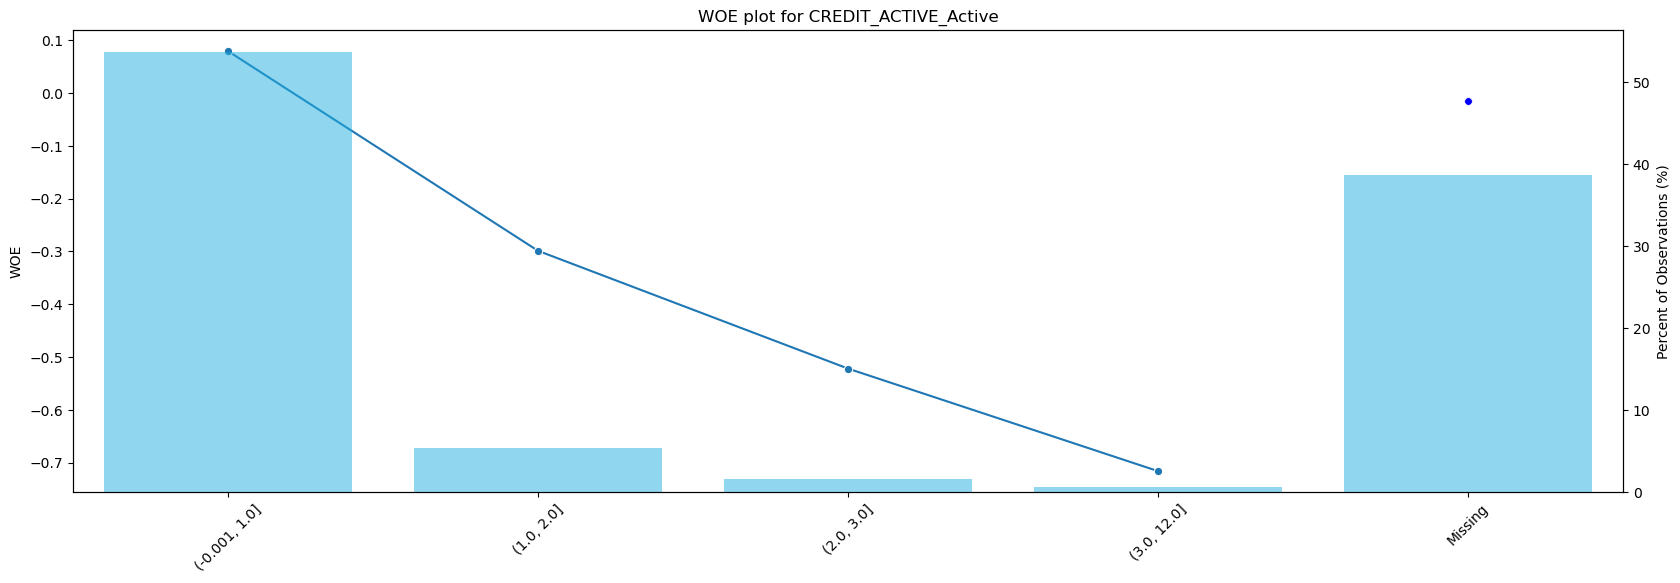

In [26]:
# test the function - create a copy first
variable = 'CREDIT_ACTIVE_Active'
woe_bin_data = df.loc[:,(variable, 'TARGET')].copy()
woe_bin_data['Bin_Range'] = pd.qcut(df[variable], q=30, duplicates='drop')
woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
woe_iv_plot(woe_bin_data, variable)

/var/folders/69/hc5tv1pn547clcgc4pkpgsp80000gn/T/ipykernel_27945/3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  working_data['Bin_Range'].fillna('Missing', inplace=True)


IV for CREDIT_ACTIVE_Active with 4 bins: 0.0221


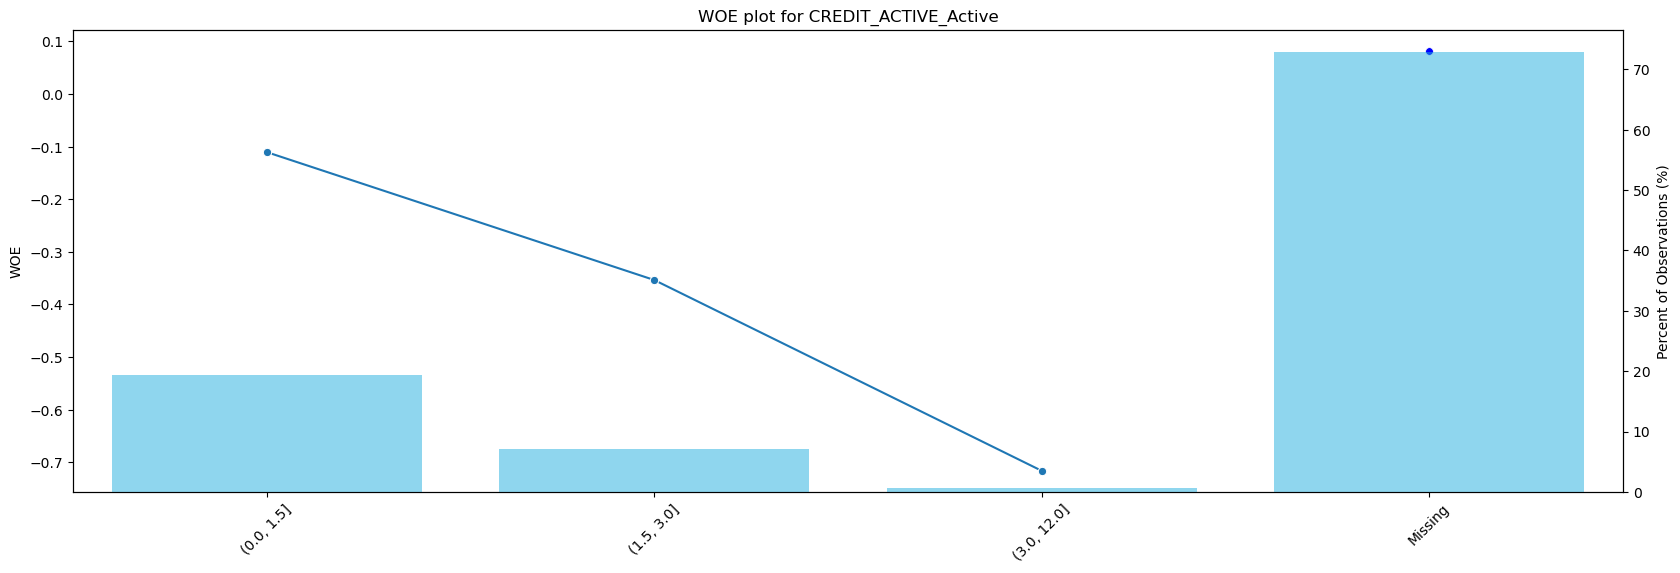

In [27]:
# sample code

bin_edges = [0.001, 1.5, 3.0, 12.0]
variable = 'CREDIT_ACTIVE_Active'

# create groupings based on specified bin edges
df['Bin_Range'] = pd.cut(df[variable], bins = bin_edges, include_lowest= True)
df['Bin_Range'].value_counts().sort_index()

woe_iv_plot(df, variable)


### AMT_GOODS_PRICE	

### AMT_ANNUITY		

### CREDIT_ACTIVE_Closed	

### CREDIT_TYPE_Credit card		

### FLAG_OWN_CAR	

### CREDIT_TYPE_Microloan	

# Categorical
### OCCUPATION_TYPE

/var/folders/69/hc5tv1pn547clcgc4pkpgsp80000gn/T/ipykernel_27945/1773856854.py:61: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
/var/folders/69/hc5tv1pn547clcgc4pkpgsp80000gn/T/ipykernel_27945/1773856854.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting v

IV for OCCUPATION_TYPE with 19 categories: 0.0799


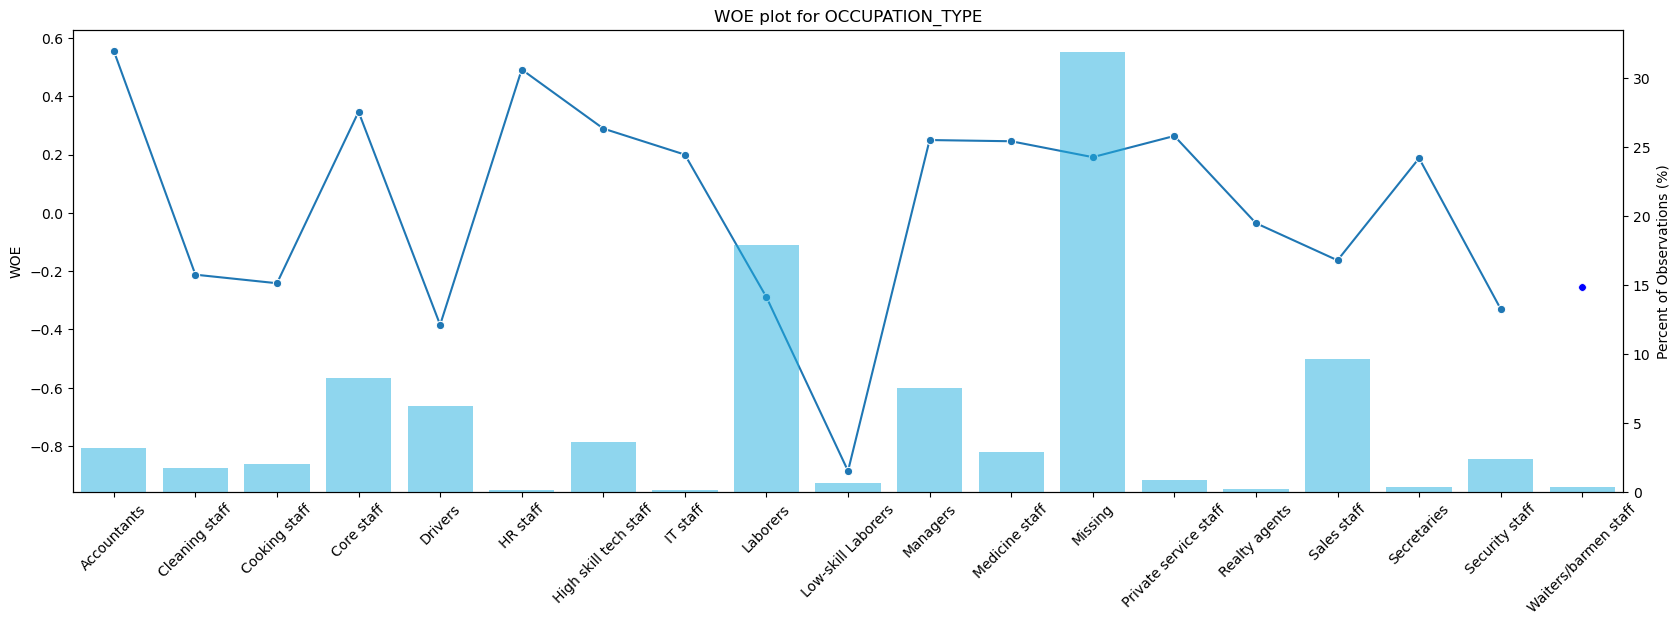

In [28]:
def woe_iv(data):
    working_data = data.copy() 
    working_data['Bin_Range'] = working_data['Bin_Range'].astype('object')
    working_data['Bin_Range'].fillna('Missing', inplace=True)
    
    variable_data = pd.DataFrame()
    variable_data['Bin_Range'] = working_data.groupby(by='Bin_Range', as_index=False).count()['Bin_Range']
    variable_data['Count'] = working_data.groupby(by='Bin_Range', as_index=False).count()['TARGET']
    variable_data['Events'] = working_data.groupby(by='Bin_Range', as_index=False).sum()['TARGET']
    variable_data['Non_Events'] = variable_data['Count'] - variable_data['Events']
    
    # Add small constant to avoid division by zero
    variable_data['%_of_Events'] = (variable_data['Events'] + 0.5) / (sum(variable_data['Events']) + 0.5 * len(variable_data))
    variable_data['%_of_Non_Events'] = (variable_data['Non_Events'] + 0.5) / (sum(variable_data['Non_Events']) + 0.5 * len(variable_data))
    
    variable_data['WOE'] = np.log(variable_data['%_of_Non_Events'] / variable_data['%_of_Events'])
    variable_data['IV'] = (variable_data['%_of_Non_Events'] - variable_data['%_of_Events']) * variable_data['WOE']
    variable_data['total_IV'] = variable_data['IV'].sum()
    
    return variable_data


# create IV calc and WOE plotting function
def woe_iv_plot(data, variable_name):
    variable_data = woe_iv(data)
    print('IV for', variable_name, 'with', variable_data.shape[0], 'categories:', round(variable_data.loc[0,'total_IV'],4))
    ffig, ax1 = plt.subplots(figsize=(20,6))

    # if 'missing' bin, do not include in plot
    if variable_data['Bin_Range'].isin(['Missing']).sum() > 0:
        sns.lineplot(data = variable_data['WOE'].iloc[0:-1], marker='o', sort = False, ax=ax1)
    else:
        sns.lineplot(data = variable_data['WOE'], marker='o', sort = False, ax=ax1)
    plt.xticks(rotation=45)

    # if 'missing' bin, create the scatter plot to plot the Missing WOE data point
    if variable_data['Bin_Range'].isin(['Missing']).sum() > 0: 
        last_point = len(variable_data['WOE']) - 1
        scatter_plot = sns.scatterplot(x=[last_point], y=[variable_data['WOE'][last_point]], color='b', s=30, ax=ax1)
    
    ax2 = ax1.twinx()
    
    # Calculate percentages instead of using raw counts
    total_count = variable_data['Count'].sum()
    variable_data['Percent'] = (variable_data['Count'] / total_count) * 100
        
    # plot the bin percentages instead of counts
    sns.barplot(x = variable_data['Bin_Range'], y = variable_data['Percent'], alpha=0.5, ax = ax2, color = 'deepskyblue')
    
    # Update y-axis label to reflect percentage
    ax2.set_ylabel('Percent of Observations (%)')
    
    plt.title("WOE plot for " + variable_name)
    plt.show()
    
# test the function for categorical variable
variable = 'OCCUPATION_TYPE'  # Example categorical variable
woe_bin_data = df.loc[:,(variable, 'TARGET')].copy()
woe_bin_data['Bin_Range'] = woe_bin_data[variable]  # Use categorical values directly instead of binning
woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
woe_iv_plot(woe_bin_data, variable)

### NAME_INCOME_TYPE

/var/folders/69/hc5tv1pn547clcgc4pkpgsp80000gn/T/ipykernel_27945/590647377.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
/var/folders/69/hc5tv1pn547clcgc4pkpgsp80000gn/T/ipykernel_27945/1773856854.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting val

IV for NAME_INCOME_TYPE with 8 categories: 0.0467


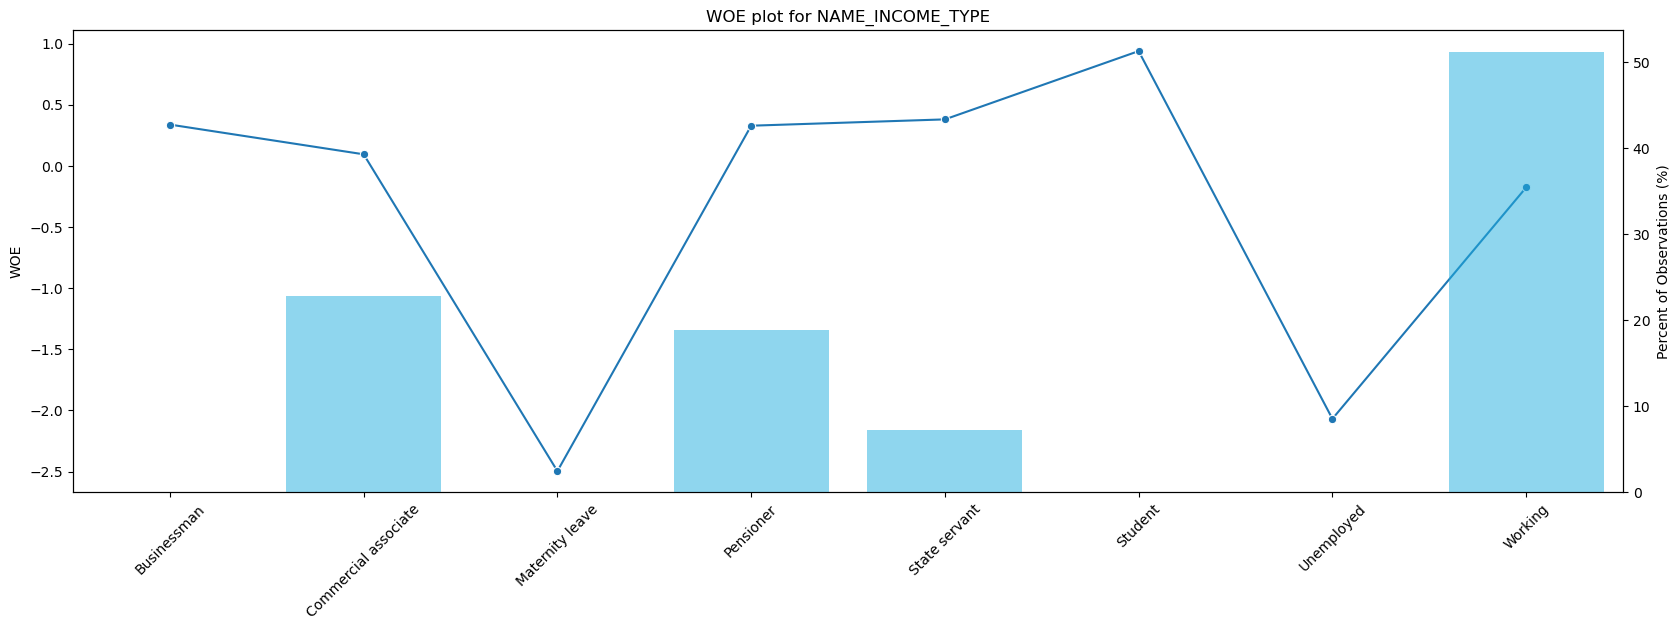

In [29]:
# test the function for categorical variable
variable = 'NAME_INCOME_TYPE'  # Example categorical variable
woe_bin_data = df.loc[:,(variable, 'TARGET')].copy()
woe_bin_data['Bin_Range'] = woe_bin_data[variable]  # Use categorical values directly instead of binning
woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
woe_iv_plot(woe_bin_data, variable)

### NAME_FAMILY_STATUS

/var/folders/69/hc5tv1pn547clcgc4pkpgsp80000gn/T/ipykernel_27945/1802753599.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
/var/folders/69/hc5tv1pn547clcgc4pkpgsp80000gn/T/ipykernel_27945/1773856854.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting va

IV for NAME_FAMILY_STATUS with 6 categories: 0.0156


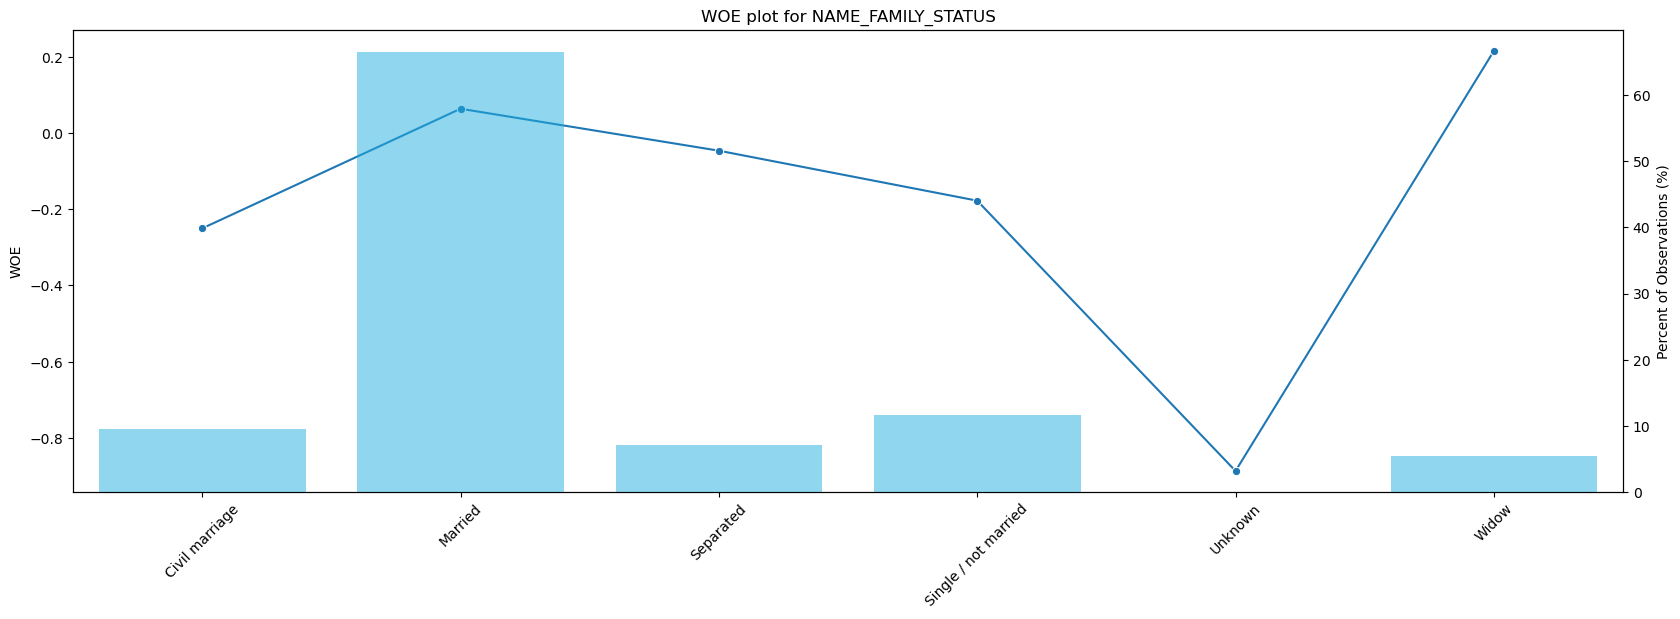

In [30]:
# test the function for categorical variable
variable = 'NAME_FAMILY_STATUS'  # Example categorical variable
woe_bin_data = df.loc[:,(variable, 'TARGET')].copy()
woe_bin_data['Bin_Range'] = woe_bin_data[variable]  # Use categorical values directly instead of binning
woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
woe_iv_plot(woe_bin_data, variable)

# scorecard creation but with custom bins 


In [31]:
import warnings

import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn import linear_model, metrics
import scorecardpy as sc
import pprint

In [32]:
DATA_PATH = Path("merged_applicant_and_bureau_cleaned_2.csv")   
df = pd.read_csv(DATA_PATH)
df

,Unnamed: 0,SK_ID_CURR,TARGET,NAME_INCOME_TYPE,NAME_FAMILY_STATUS,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,OCCUPATION_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,AGE,AMT_CREDIT_SUM_sum,AMT_CREDIT_SUM_DEBT_sum,AMT_CREDIT_SUM_OVERDUE_max,CREDIT_DAY_OVERDUE_max,CNT_CREDIT_PROLONG_sum,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Closed,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Microloan,CREDIT_TYPE_Unknown type of loan,CREDIT_TYPE_Another type of loan,DEBT_RATIO,OVERDUE_RATIO,YEARS_EMPLOYED
0,0,100003,0,State servant,Married,0,270000.0,1293502.5,35698.5,1129500.0,Core staff,N,N,45.931507,94900.5,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3.254795
1,1,100004,0,Working,Single / not married,0,67500.0,135000.0,6750.0,135000.0,Laborers,Y,Y,52.180822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.616438
2,2,100006,0,Working,Civil marriage,0,135000.0,312682.5,29686.5,297000.0,Laborers,N,Y,52.068493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.326027
3,3,100007,0,Working,Single / not married,0,121500.0,513000.0,21865.5,513000.0,Core staff,N,Y,54.608219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.323288
4,4,100008,0,State servant,Married,0,99000.0,490495.5,27517.5,454500.0,Laborers,N,Y,46.413699,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.350685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254353,254353,456248,0,Working,Separated,0,153000.0,331920.0,16096.5,225000.0,Sales staff,N,Y,45.767123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.884932
254354,254354,456252,0,Pensioner,Widow,0,72000.0,269550.0,12001.5,225000.0,NaN,N,Y,56.917808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254355,254355,456253,0,Working,Separated,0,153000.0,677664.0,29979.0,585000.0,Managers,N,Y,41.002740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.701370
254356,254356,456254,1,Commercial associate,Married,0,171000.0,370107.0,20205.0,319500.0,Laborers,N,Y,32.769863,45000.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,13.112329


In [33]:
df = df[[
    "TARGET",
    "DEBT_RATIO",
    "AMT_ANNUITY",
    "NAME_INCOME_TYPE",
    "AMT_CREDIT",
    "AGE",
    "OCCUPATION_TYPE",
    "AMT_CREDIT_SUM_DEBT_sum",
    "YEARS_EMPLOYED"
]]
df

,TARGET,DEBT_RATIO,AMT_ANNUITY,NAME_INCOME_TYPE,AMT_CREDIT,AGE,OCCUPATION_TYPE,AMT_CREDIT_SUM_DEBT_sum,YEARS_EMPLOYED
0,0,0.0,35698.5,State servant,1293502.5,45.931507,Core staff,0.0,3.254795
1,0,NaN,6750.0,Working,135000.0,52.180822,Laborers,NaN,0.616438
2,0,NaN,29686.5,Working,312682.5,52.068493,Laborers,NaN,8.326027
3,0,NaN,21865.5,Working,513000.0,54.608219,Core staff,NaN,8.323288
4,0,NaN,27517.5,State servant,490495.5,46.413699,Laborers,NaN,4.350685
...,...,...,...,...,...,...,...,...,...
254353,0,NaN,16096.5,Working,331920.0,45.767123,Sales staff,NaN,19.884932
254354,0,NaN,12001.5,Pensioner,269550.0,56.917808,NaN,NaN,NaN
254355,0,NaN,29979.0,Working,677664.0,41.002740,Managers,NaN,21.701370
254356,1,0.0,20205.0,Commercial associate,370107.0,32.769863,Laborers,0.0,13.112329


In [34]:
df.isnull().sum()


TARGET                         0
DEBT_RATIO                 98302
AMT_ANNUITY                    9
NAME_INCOME_TYPE               0
AMT_CREDIT                     0
AGE                            0
OCCUPATION_TYPE            81149
AMT_CREDIT_SUM_DEBT_sum    98302
YEARS_EMPLOYED             47945
dtype: int64

In [35]:
# Fill numeric columns with 0
df['DEBT_RATIO'] = df['DEBT_RATIO'].fillna(0)
df['AMT_ANNUITY'] = df['AMT_ANNUITY'].fillna(0)
df['AMT_CREDIT_SUM_DEBT_sum'] = df['AMT_CREDIT_SUM_DEBT_sum'].fillna(0)
df['YEARS_EMPLOYED'] = df['YEARS_EMPLOYED'].fillna(0)

# Fill OCCUPATION_TYPE with 'MISSING'
df['OCCUPATION_TYPE'] = df['OCCUPATION_TYPE'].fillna('MISSING')

# Verify no missing values remain
print(df.isnull().sum())

TARGET                     0
DEBT_RATIO                 0
AMT_ANNUITY                0
NAME_INCOME_TYPE           0
AMT_CREDIT                 0
AGE                        0
OCCUPATION_TYPE            0
AMT_CREDIT_SUM_DEBT_sum    0
YEARS_EMPLOYED             0
dtype: int64


/var/folders/69/hc5tv1pn547clcgc4pkpgsp80000gn/T/ipykernel_27945/3745332102.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DEBT_RATIO'] = df['DEBT_RATIO'].fillna(0)
/var/folders/69/hc5tv1pn547clcgc4pkpgsp80000gn/T/ipykernel_27945/3745332102.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AMT_ANNUITY'] = df['AMT_ANNUITY'].fillna(0)
/var/folders/69/hc5tv1pn547clcgc4pkpgsp80000gn/T/ipykernel_27945/3745332102.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [36]:
train, test = sc.split_df(df, y = 'TARGET', ratio = .7).values()
print(train.shape)
print(test.shape)

(178050, 9)
(76308, 9)


In [37]:
custom_breaks = {
    'DEBT_RATIO': [-np.inf, 0.22, np.inf],
    'AMT_ANNUITY': [0, 16000, 36000, 44000, 60000],
    'NAME_INCOME_TYPE': ["Businessman", "Commercial associate", "Pensioner", "State servant", "Student", "Working"],
    'AMT_CREDIT': [0, 150000, 300000, 650000, 1100000, 1350000, 4000000],
    'AGE': [30, 39, 53, 57, 70],
    'OCCUPATION_TYPE': ["Accountants", "Core staff", "Drivers", "High skill tech staff", "Laborers", "MISSING", "Managers", "Medicine staff", "OTHER", "Sales staff", "Security staff"],
    'AMT_CREDIT_SUM_DEBT_sum': [0, 8000, 44000, 900000],
    'YEARS_EMPLOYED': [0, 4.0, 9, 15, 50]
}

# Step 4: Apply `woebin` with custom bins (force custom binning)
bins = sc.woebin(train, y='TARGET', breaks_list=custom_breaks)

# Step 5: Display the results for verification
for variable, bin_details in bins.items():
    print(variable, " : ")
    display(bin_details)  # Use display() in Jupyter notebooks or print if you're running in a script
    print("--" * 50)

[INFO] creating woe binning ...


/opt/anaconda3/lib/python3.12/site-packages/scorecardpy/condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
/opt/anaconda3/lib/python3.12/site-packages/scorecardpy/condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
/opt/anaconda3/lib/python3.12/site-packages/scorecardpy/condition_fun.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensur

AMT_CREDIT  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_CREDIT,"[-inf,150000.0)",9684,0.054389,9137,547,0.056485,-0.319500,0.004854,0.048039,150000.0,False
1,AMT_CREDIT,"[150000.0,300000.0)",36321,0.203993,33590,2731,0.075191,-0.013422,0.000037,0.048039,300000.0,False
2,AMT_CREDIT,"[300000.0,650000.0)",59434,0.333805,53862,5572,0.093751,0.227467,0.019024,0.048039,650000.0,False
3,AMT_CREDIT,"[650000.0,1100000.0)",49028,0.275361,45543,3485,0.071082,-0.074051,0.001463,0.048039,1100000.0,False
4,AMT_CREDIT,"[1100000.0,1350000.0)",13075,0.073434,12297,778,0.059503,-0.264246,0.004587,0.048039,1350000.0,False
5,AMT_CREDIT,"[1350000.0,4000000.0)",10501,0.058978,10060,441,0.041996,-0.631139,0.018065,0.048039,4000000.0,False
6,AMT_CREDIT,"[4000000.0,inf)",7,0.000039,7,0,0.000000,0.444867,0.000011,0.048039,inf,False


----------------------------------------------------------------------------------------------------
AGE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AGE,"[-inf,39.0)",51545,0.289497,46523,5022,0.097429,0.270086,0.023686,0.054217,39.0,False
1,AGE,"[39.0,53.0)",73605,0.413395,68015,5590,0.075946,-0.002544,0.000003,0.054217,53.0,False
2,AGE,"[53.0,57.0)",19916,0.111856,18708,1208,0.060655,-0.243781,0.005998,0.054217,57.0,False
3,AGE,"[57.0,70.0)",32984,0.185251,31250,1734,0.052571,-0.395384,0.024530,0.054217,70.0,False


----------------------------------------------------------------------------------------------------
DEBT_RATIO  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DEBT_RATIO,"[-inf,0.22)",162870,0.914743,151244,11626,0.071382,-0.069446,0.004284,0.039354,0.22,False
1,DEBT_RATIO,"[0.22,inf)",15180,0.085257,13252,1928,0.127009,0.568539,0.035070,0.039354,inf,False


----------------------------------------------------------------------------------------------------
AMT_CREDIT_SUM_DEBT_sum  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_CREDIT_SUM_DEBT_sum,"[-inf,8000.0)",156394,0.878371,145323,11071,0.070789,-0.078492,0.005235,0.037697,8000.0,False
1,AMT_CREDIT_SUM_DEBT_sum,"[8000.0,44000.0)",11843,0.066515,10620,1223,0.103268,0.334706,0.008590,0.037697,44000.0,False
2,AMT_CREDIT_SUM_DEBT_sum,"[44000.0,900000.0)",9809,0.055091,8549,1260,0.128453,0.581436,0.023830,0.037697,900000.0,False
3,AMT_CREDIT_SUM_DEBT_sum,"[900000.0,inf)",4,0.000022,4,0,0.000000,1.004483,0.000042,0.037697,inf,False


----------------------------------------------------------------------------------------------------
AMT_ANNUITY  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_ANNUITY,"[-inf,16000.0)",37920,0.212974,35364,2556,0.067405,-0.131046,0.003460,0.027541,16000.0,False
1,AMT_ANNUITY,"[16000.0,36000.0)",97105,0.545381,88908,8197,0.084414,0.112371,0.007223,0.027541,36000.0,False
2,AMT_ANNUITY,"[36000.0,44000.0)",20466,0.114945,18933,1533,0.074905,-0.017475,0.000035,0.027541,44000.0,False
3,AMT_ANNUITY,"[44000.0,60000.0)",17456,0.098040,16375,1081,0.061927,-0.221665,0.004387,0.027541,60000.0,False
4,AMT_ANNUITY,"[60000.0,inf)",5103,0.028660,4916,187,0.036645,-0.772937,0.012435,0.027541,inf,False


----------------------------------------------------------------------------------------------------
YEARS_EMPLOYED  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,YEARS_EMPLOYED,"[-inf,4.0)",91859,0.515917,83966,7893,0.085925,0.131769,0.009473,0.042417,4.0,False
1,YEARS_EMPLOYED,"[4.0,9.0)",45229,0.254024,41735,3494,0.077251,0.015912,0.000065,0.042417,9.0,False
2,YEARS_EMPLOYED,"[9.0,15.0)",24714,0.138804,23278,1436,0.058105,-0.289443,0.010294,0.042417,15.0,False
3,YEARS_EMPLOYED,"[15.0,50.0)",16248,0.091255,15517,731,0.044990,-0.559073,0.022586,0.042417,50.0,False


----------------------------------------------------------------------------------------------------
OCCUPATION_TYPE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,OCCUPATION_TYPE,Accountants,5704,0.032036,5442,262,0.045933,-0.537353,0.007390,0.070551,Accountants,False
1,OCCUPATION_TYPE,Core staff,14692,0.082516,13891,801,0.054519,-0.356931,0.009048,0.070551,Core staff,False
2,OCCUPATION_TYPE,Drivers,11202,0.062915,9998,1204,0.107481,0.379469,0.010644,0.070551,Drivers,False
3,OCCUPATION_TYPE,High skill tech staff,6491,0.036456,6101,390,0.060083,-0.253857,0.002111,0.070551,High skill tech staff,False
4,OCCUPATION_TYPE,Laborers,31734,0.178231,28584,3150,0.099263,0.290760,0.017049,0.070551,Laborers,False
5,OCCUPATION_TYPE,MISSING,56697,0.318433,53071,3626,0.063954,-0.187296,0.010321,0.070551,MISSING,False
6,OCCUPATION_TYPE,Managers,13427,0.075411,12621,806,0.060028,-0.254829,0.004398,0.070551,Managers,False
7,OCCUPATION_TYPE,Medicine staff,5167,0.029020,4846,321,0.062125,-0.218263,0.001261,0.070551,Medicine staff,False
8,OCCUPATION_TYPE,Sales staff,17143,0.096282,15639,1504,0.087733,0.154565,0.002456,0.070551,Sales staff,False
9,OCCUPATION_TYPE,Security staff,4245,0.023842,3802,443,0.104358,0.346492,0.003316,0.070551,Security staff,False


----------------------------------------------------------------------------------------------------
NAME_INCOME_TYPE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NAME_INCOME_TYPE,Businessman,4,0.000022,4,0,0.000000,1.004417,0.000042,0.04844,Businessman,False
1,NAME_INCOME_TYPE,Commercial associate,40595,0.227998,37771,2824,0.069565,-0.097316,0.002072,0.04844,Commercial associate,False
2,NAME_INCOME_TYPE,Pensioner,33585,0.188627,31707,1878,0.055918,-0.330258,0.017905,0.04844,Pensioner,False
3,NAME_INCOME_TYPE,State servant,12838,0.072103,12161,677,0.052734,-0.392246,0.009409,0.04844,State servant,False
4,NAME_INCOME_TYPE,Student,8,0.000045,8,0,0.000000,0.311270,0.000006,0.04844,Student,False
5,NAME_INCOME_TYPE,Working,91003,0.511109,82836,8167,0.089744,0.179311,0.017733,0.04844,Working,False
6,NAME_INCOME_TYPE,missing,17,0.000095,9,8,0.470588,2.378289,0.001273,0.04844,missing,False


----------------------------------------------------------------------------------------------------


In [38]:
# sample code

# prepare a dataset with the WOE values for Logistic Regression training
# woebin_ply() converts original values of input data into woe
train_woe = sc.woebin_ply(train, bins)
test_woe = sc.woebin_ply(test, bins)
train_woe

[INFO] converting into woe values ...
[INFO] converting into woe values ...


,TARGET,AMT_CREDIT_woe,AGE_woe,DEBT_RATIO_woe,AMT_CREDIT_SUM_DEBT_sum_woe,AMT_ANNUITY_woe,YEARS_EMPLOYED_woe,OCCUPATION_TYPE_woe,NAME_INCOME_TYPE_woe
0,0,-0.264246,-0.002544,-0.069446,-0.078492,0.112371,0.131769,-0.356931,-0.392246
1,0,-0.319500,-0.002544,-0.069446,-0.078492,-0.131046,0.131769,0.290760,0.179311
3,0,0.227467,-0.243781,-0.069446,-0.078492,0.112371,0.015912,-0.356931,0.179311
5,0,-0.631139,0.270086,-0.069446,-0.078492,-0.017475,0.015912,-0.537353,-0.097316
6,0,-0.631139,-0.002544,-0.069446,-0.078492,-0.017475,0.131769,-0.254829,-0.392246
...,...,...,...,...,...,...,...,...,...
254350,0,-0.013422,0.270086,-0.069446,-0.078492,-0.131046,0.131769,NaN,-0.097316
254352,0,0.227467,0.270086,-0.069446,-0.078492,0.112371,0.131769,-0.356931,-0.097316
254353,0,0.227467,-0.002544,-0.069446,-0.078492,0.112371,NaN,0.154565,0.179311
254354,0,-0.013422,-0.243781,-0.069446,-0.078492,-0.131046,0.131769,-0.187296,-0.330258


In [39]:
y_train = train_woe.loc[:, 'TARGET']
X_train = train_woe.loc[:, train_woe.columns != 'TARGET']
y_test = test_woe.loc[:, 'TARGET']
X_test = test_woe.loc[:, train_woe.columns != 'TARGET']

#THIS NOT THE RIGHT THING TO DO I THINK 
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

# create a logistic regression model object
lr = linear_model.LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)
pd.Series(np.concatenate([lr.intercept_, lr.coef_[0]]),
          index = np.concatenate([['intercept'], lr.feature_names_in_]) )

intercept                     -0.093505
AMT_CREDIT_woe                 0.666753
AGE_woe                        0.857674
DEBT_RATIO_woe                 0.522395
AMT_CREDIT_SUM_DEBT_sum_woe    0.466819
AMT_ANNUITY_woe                0.441310
YEARS_EMPLOYED_woe             1.259354
OCCUPATION_TYPE_woe            0.746645
NAME_INCOME_TYPE_woe           0.642879
dtype: float64

In [40]:
# sample code

# generate a card from the model and bins. The scores will be based on probability of default from the model
# bins = bins created from sc.woebin
# lr = fitted logistic regression model
# align target odds with probabity of default = 5%
# odds = p/(1-p) = 0.05/(1-0.05) = 0.0526 ~= 1/19
card = sc.scorecard(bins, lr, X_train.columns, points0 = 600, odds0 = 1/19, pdo = 20, basepoints_eq0 = True)

pprint.pprint(card)

{'AGE':    variable          bin  points
7       AGE  [-inf,39.0)    58.0
8       AGE  [39.0,53.0)    65.0
9       AGE  [53.0,57.0)    71.0
10      AGE  [57.0,70.0)    75.0,
 'AMT_ANNUITY':        variable                bin  points
17  AMT_ANNUITY     [-inf,16000.0)    66.0
18  AMT_ANNUITY  [16000.0,36000.0)    63.0
19  AMT_ANNUITY  [36000.0,44000.0)    65.0
20  AMT_ANNUITY  [44000.0,60000.0)    68.0
21  AMT_ANNUITY      [60000.0,inf)    75.0,
 'AMT_CREDIT':      variable                    bin  points
0  AMT_CREDIT        [-inf,150000.0)    71.0
1  AMT_CREDIT    [150000.0,300000.0)    65.0
2  AMT_CREDIT    [300000.0,650000.0)    60.0
3  AMT_CREDIT   [650000.0,1100000.0)    66.0
4  AMT_CREDIT  [1100000.0,1350000.0)    70.0
5  AMT_CREDIT  [1350000.0,4000000.0)    77.0
6  AMT_CREDIT        [4000000.0,inf)    56.0,
 'AMT_CREDIT_SUM_DEBT_sum':                    variable                 bin  points
13  AMT_CREDIT_SUM_DEBT_sum       [-inf,8000.0)    66.0
14  AMT_CREDIT_SUM_DEBT_sum    [800

In [41]:
# sample code

# credit score for samples in test and train
train_score = sc.scorecard_ply(train, card)
test_score = sc.scorecard_ply(test, card)

# sample code

# check model performance at 1:5 odds of default
cutoff = 500

# create sets of predicted bad to compare with actual bad
predicted_bad_train = (train_score < cutoff)
predicted_bad_train_list = predicted_bad_train.astype(int).values.flatten().tolist()
predicted_bad_test = (test_score < cutoff)
predicted_bad_test_list = predicted_bad_test.astype(int).values.flatten().tolist()

print('*** Training Data Performance ***')
print('Confusion matrix:')
print(metrics.confusion_matrix(y_train, predicted_bad_train_list))
print('PCC measures:')
print(metrics.classification_report(y_train, predicted_bad_train_list))
 
print('*** Test Data Performance ***')
print('Confusion matrix:')
print(metrics.confusion_matrix(y_test, predicted_bad_test_list))
print('PCC measures:')
print(metrics.classification_report(y_test, predicted_bad_test_list))

*** Training Data Performance ***
Confusion matrix:
[[98077 66419]
 [ 7826  5728]]
PCC measures:
              precision    recall  f1-score   support

           0       0.93      0.60      0.73    164496
           1       0.08      0.42      0.13     13554

    accuracy                           0.58    178050
   macro avg       0.50      0.51      0.43    178050
weighted avg       0.86      0.58      0.68    178050

*** Test Data Performance ***
Confusion matrix:
[[42382 28117]
 [ 3298  2511]]
PCC measures:
              precision    recall  f1-score   support

           0       0.93      0.60      0.73     70499
           1       0.08      0.43      0.14      5809

    accuracy                           0.59     76308
   macro avg       0.50      0.52      0.43     76308
weighted avg       0.86      0.59      0.68     76308



Train AUC: 0.531
Test  AUC: 0.542


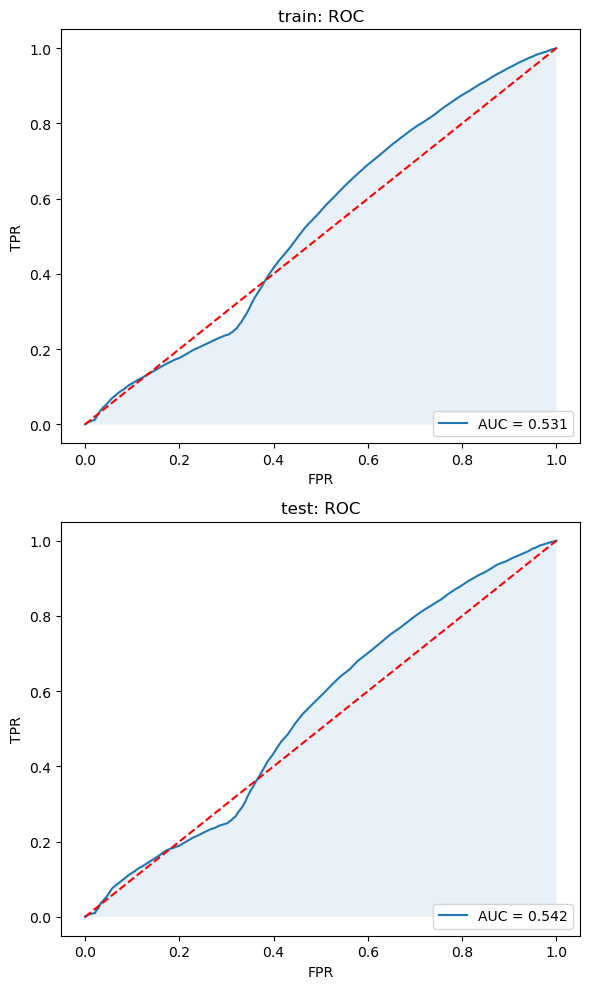

In [42]:
train_decision = -train_score['score']
test_decision  = -test_score['score']
train_decision = -train_score
test_decision  = -test_score

# --- Compute ROC and AUC for train ---
fpr_train, tpr_train, _ = metrics.roc_curve(y_train, train_decision)
auc_train = metrics.roc_auc_score(y_train, train_decision)

# --- Compute ROC and AUC for test ---
fpr_test, tpr_test, _ = metrics.roc_curve(y_test, test_decision)
auc_test = metrics.roc_auc_score(y_test, test_decision)

print(f"Train AUC: {auc_train:.3f}")
print(f"Test  AUC: {auc_test:.3f}")

# --- Plot ROC curves (train + test) ---
fig, axes = plt.subplots(2, 1, figsize=(6, 10))

# Train ROC
axes[0].plot(fpr_train, tpr_train, label=f"AUC = {auc_train:.3f}")
axes[0].plot([0, 1], [0, 1], 'r--')  # random baseline
axes[0].set_title("train: ROC")
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[0].fill_between(fpr_train, tpr_train, alpha=0.1)
axes[0].legend(loc="lower right")

# Test ROC
axes[1].plot(fpr_test, tpr_test, label=f"AUC = {auc_test:.3f}")
axes[1].plot([0, 1], [0, 1], 'r--')  # random baseline
axes[1].set_title("test: ROC")
axes[1].set_xlabel("FPR")
axes[1].set_ylabel("TPR")
axes[1].fill_between(fpr_test, tpr_test, alpha=0.1)
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()